In [113]:
import pandas as pd
import numpy as np

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


In [114]:
train = pd.read_csv("/content/cleaned_train (1).csv")
test = pd.read_csv("/content/test_9000.csv")


In [115]:
y_train = train["Tenure"]
X_train = train.drop(["Tenure", "CustomerID"], axis=1)

y_test = test["Tenure"]
X_test = test.drop(["Tenure", "CustomerID"], axis=1)

y_max = y_test.max()
y_min = y_test.min()
y_mean = y_test.mean()

In [116]:
cat_cols = X_train.select_dtypes(include=['object']).columns
num_cols = X_train.select_dtypes(exclude=['object']).columns

preprocess = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),

        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median"))
        ]), num_cols)
    ]
)


In [117]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Define column groups
cat_cols = X_train.select_dtypes(include=['object']).columns
num_cols = X_train.select_dtypes(exclude=['object']).columns

preprocess = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),

        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            # Add Scaling here
            ("scaler", StandardScaler())
        ]), num_cols)
    ]
)

In [118]:
# 1. FIT and TRANSFORM the Training Data
# The pipeline learns the Mean/Median/Scale from X_train
X_train_processed = preprocess.fit_transform(X_train)

# 2. TRANSFORM the Test Data
# The pipeline applies the rules learned from Train to Test
X_test_processed = preprocess.transform(X_test)

In [137]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Fit and Predict
lin_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

# Calculate Range for Normalization
data_range = 2*(y_max - y_min)


# 1. Normalized MAE (Good to know error % relative to range)
n_mae = mean_absolute_error(y_test, y_pred_lin) / data_range
print(f"Linear Regression MAE:  {n_mae:.2%}")

# 2. Normalized RMSE
n_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lin)) / data_range
print(f"Linear Regression RMSE: {n_rmse:.2%}")

# 3. R² Score
r2 = -r2_score(y_test, y_pred_lin)
print(f"R² Score: {r2:.2}")

Linear Regression MAE:  13.19%
Linear Regression RMSE: 15.49%
R² Score: 0.11


In [130]:
rf_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(random_state=42))
])

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


print("Random Forest MAE:", mean_absolute_error(y_test, y_pred_rf)/data_range)
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf))/data_range)
print("Random Forest R²:", 1+r2_score(y_test, y_pred_rf))


Random Forest MAE: 0.14118020715630883
Random Forest RMSE: 0.17020230863362362
Random Forest R²: 0.6581458833077256


In [129]:
xgb_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)


print("XGBoost MAE:", mean_absolute_error(y_test, y_pred_xgb)/data_range)
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb))/data_range)
print("XGBoost R²:", 1+r2_score(y_test, y_pred_xgb))


XGBoost MAE: 0.137153037217586
XGBoost RMSE: 0.1638251640137536
XGBoost R²: 0.7568153687200752


In [122]:
xgb_params = {
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__max_depth": [3, 5, 7],
    "model__n_estimators": [100, 200, 300]
}

xgb_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_params,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

xgb_search.fit(X_train, y_train)
print("\nBest XGB Params:", xgb_search.best_params_)
print("Best XGB Score (MAE):", -xgb_search.best_score_/data_range)



Best XGB Params: {'model__learning_rate': 0.01, 'model__max_depth': 7, 'model__n_estimators': 300}
Best XGB Score (MAE): 0.10487779789725267


In [136]:
from sklearn.model_selection import GridSearchCV

# 1. Define the Grid
xgb_params = {
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__max_depth": [3, 5, 7],
    "model__n_estimators": [100, 200, 300]
}

# 2. Setup GridSearchCV
# We optimize for MAE (Negative MAE is used because sklearn tries to 'maximize' score)
xgb_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_params,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1 # Shows progress bar
)

# 3. Fit (Find the best model)
print("Running Grid Search...")
xgb_search.fit(X_train, y_train)

# --- RESULTS ANALYSIS ---

# A. The Best Parameters Found
print("\nBest Hyperparameters:", xgb_search.best_params_)

# B. Get the Best Model and Predict on Test Set
best_xgb = xgb_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)

# Calculate Range (Ensure this is defined)
data_range = y_max - y_min

# C. Calculate All Metrics on TEST Data
mae_test = mean_absolute_error(y_test, y_pred_best)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_test = r2_score(y_test, y_pred_best)

print("\n--- Test Set Performance (Best Model) ---")
print(f"Normalized MAE:  {mae_test / data_range:.2%}")
print(f"Normalized RMSE: {rmse_test / data_range:.2%}")
print(f"R² Score:        {1+r2_test:.4f}")

Running Grid Search...
Fitting 3 folds for each of 27 candidates, totalling 81 fits

Best Hyperparameters: {'model__learning_rate': 0.01, 'model__max_depth': 7, 'model__n_estimators': 300}

--- Test Set Performance (Best Model) ---
Normalized MAE:  26.94%
Normalized RMSE: 31.99%
R² Score:        0.8148


/tmp/ipython-input-3521732460.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(


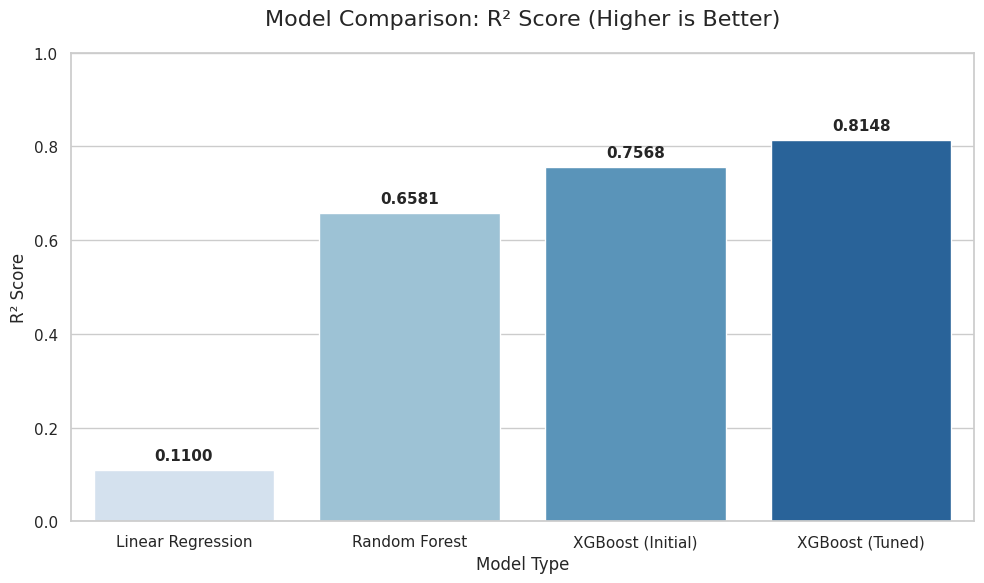

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Define the Data (extracted from your output)
data = {
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost (Initial)', 'XGBoost (Tuned)'],
    'R2_Score': [0.1100, 0.6581, 0.7568, 0.8148]
}

# Create a DataFrame
df = pd.DataFrame(data)

# 2. Setup the Plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create Bar Plot
# using a color palette that gets darker as performance improves
plot = sns.barplot(
    data=df,
    x='Model',
    y='R2_Score',
    palette="Blues"
)

# 3. Customization
plt.title('Model Comparison: R² Score (Higher is Better)', fontsize=16, pad=20)
plt.ylabel('R² Score', fontsize=12)
plt.xlabel('Model Type', fontsize=12)
plt.ylim(0, 1.0)  # R² is typically 0-1

# 4. Add Labels on top of bars
for i in plot.containers:
    plot.bar_label(i, fmt='%.4f', padding=5, fontsize=11, fontweight='bold')

# Show the graph
plt.tight_layout()
plt.show()

In [141]:
# best model is xgboost tuned

import pickle

# Save the tuned XGBoost model
with open("best_xgboost_tuned.pkl", "wb") as f:
    pickle.dump(best_xgb, f)

print("Tuned XGBoost model saved as best_xgboost_tuned.pkl")


Tuned XGBoost model saved as best_xgboost_tuned.pkl


In [145]:
import sklearn
print(sklearn.__version__)


1.6.1
